In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
import xgboost as xgb


In [19]:
import sqlite3

conn = sqlite3.connect('../data/WARP.db')
df = pd.read_sql_query("SELECT * FROM master_warp", conn)
conn.close()
# change datetime to datetime64
df.set_index('datetime')
df['datetime'] = pd.to_datetime(df['datetime'])
print(df.dtypes)


datetime                    datetime64[ns, UTC]
hour                                      int64
day_of_week                               int64
month                                     int64
day_of_year                               int64
date                                     object
hour_sin                                float64
hour_cos                                float64
weekday_sin                             float64
weekday_cos                             float64
yearday_sin                             float64
yearday_cos                             float64
is_holiday                                int64
is_weekend                                int64
is_non_working_day                        int64
Load                                    float64
Price                                   float64
Flow_BE_to_NL                           float64
Flow_NL_to_BE                           float64
Flow_DE_to_NL                           float64
Flow_NL_to_DE                           

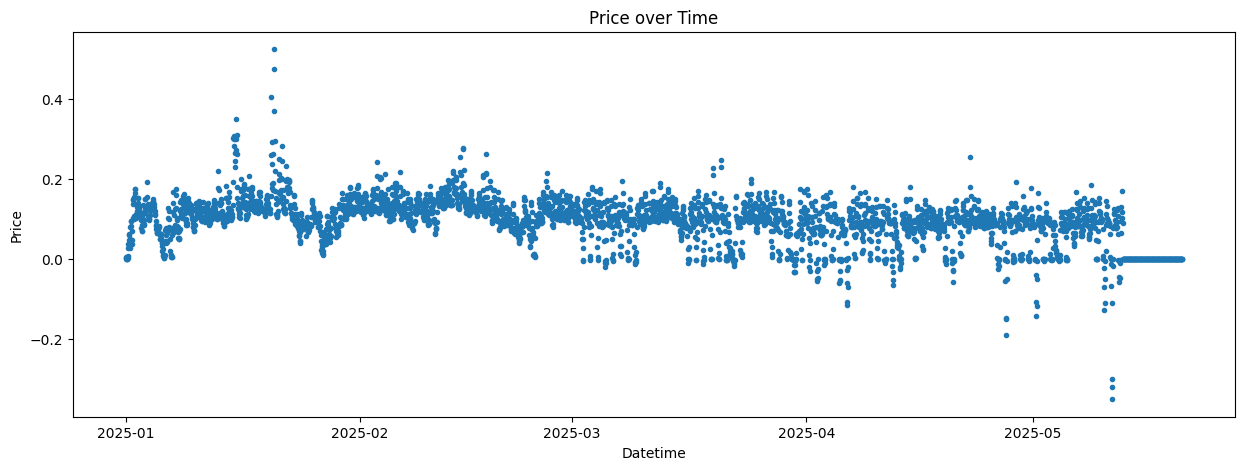

In [20]:

plt.figure(figsize=(15, 5))
plt.plot(df['datetime'], df['Price'], '.', color=color_pal[0])
plt.title('Price over Time')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.show()

# Train Test Split

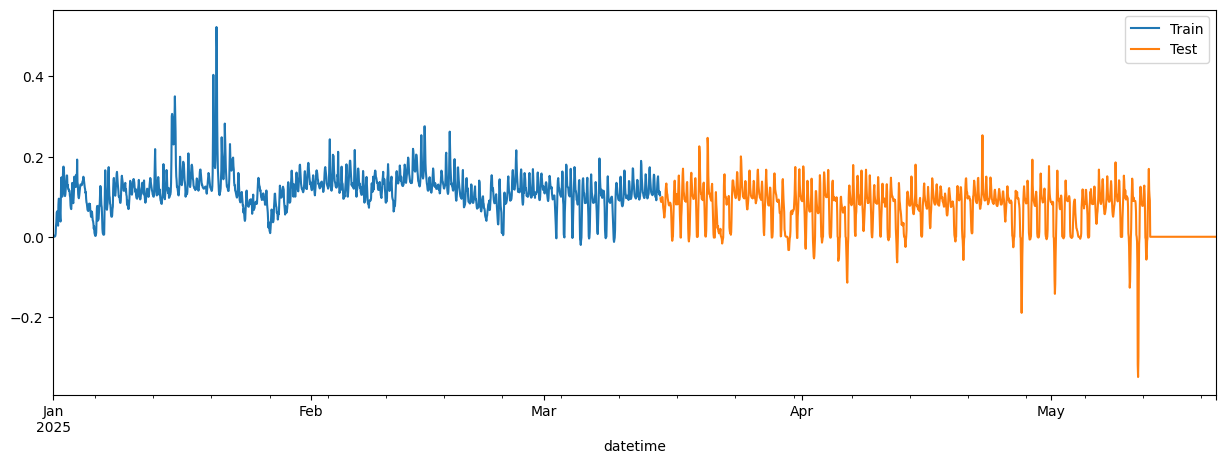

In [21]:
train = df.loc[df['datetime'] < '2025-03-15']
test = df.loc[df['datetime'] >= '2025-03-15']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(x='datetime', y='Price', ax=ax, label='Train', color=color_pal[0])
test.plot(x='datetime', y='Price', ax=ax, label='Test', color=color_pal[1])
plt.legend()
plt.show()



In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from datetime import timedelta

# Feature and target setup
features = ['Solar_Vol', 'temperature_2m', 'Total_Flow']
target = 'Price'

# Safe datetime handling
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    df = df.set_index('datetime')
else:
    print("'datetime' column not found in columns. Sorting by index instead.")
    df = df.sort_index()

# Forecast settings
start_date = pd.Timestamp("2025-03-13 12:00", tz='UTC')
end_date = pd.Timestamp("2025-05-05 12:00", tz='UTC')
lag = timedelta(hours=36)
forecast_horizon = timedelta(hours=144)

# Store RMSEs
rmses = []

current_time = start_date
while current_time <= end_date:
    train_data = df[df.index < current_time]
    test_start = current_time + lag
    test_end = test_start + forecast_horizon
    test_data = df[(df.index >= test_start) & (df.index < test_end)]

    if test_data.empty:
        print(f"No test data for forecast starting at {current_time}")
        current_time += timedelta(days=1)
        continue

    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    # Train and predict
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses.append(rmse)

    print(f"Forecast origin: {current_time}, Predicting {test_start} to {test_end}, RMSE: {rmse:.3f}")

    current_time += timedelta(days=1)

# Summary
avg_rmse = np.mean(rmses)
print(f"\nAverage RMSE over {len(rmses)} runs: {avg_rmse:.3f}")

'datetime' column not found in columns. Sorting by index instead.
Forecast origin: 2025-03-13 12:00:00+00:00, Predicting 2025-03-15 00:00:00+00:00 to 2025-03-21 00:00:00+00:00, RMSE: 0.052
Forecast origin: 2025-03-14 12:00:00+00:00, Predicting 2025-03-16 00:00:00+00:00 to 2025-03-22 00:00:00+00:00, RMSE: 0.052
Forecast origin: 2025-03-15 12:00:00+00:00, Predicting 2025-03-17 00:00:00+00:00 to 2025-03-23 00:00:00+00:00, RMSE: 0.056
Forecast origin: 2025-03-16 12:00:00+00:00, Predicting 2025-03-18 00:00:00+00:00 to 2025-03-24 00:00:00+00:00, RMSE: 0.059
Forecast origin: 2025-03-17 12:00:00+00:00, Predicting 2025-03-19 00:00:00+00:00 to 2025-03-25 00:00:00+00:00, RMSE: 0.057
Forecast origin: 2025-03-18 12:00:00+00:00, Predicting 2025-03-20 00:00:00+00:00 to 2025-03-26 00:00:00+00:00, RMSE: 0.054
Forecast origin: 2025-03-19 12:00:00+00:00, Predicting 2025-03-21 00:00:00+00:00 to 2025-03-27 00:00:00+00:00, RMSE: 0.052
Forecast origin: 2025-03-20 12:00:00+00:00, Predicting 2025-03-22 00:00:0

In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from datetime import timedelta

# Feature and target setup
features = ['Solar_Vol', 'Wind_Vol', 'temperature_2m', 'Total_Flow', 'weekday_sin', 'weekday_cos', 'yearday_sin',
            'yearday_cos', 'hour_sin', 'hour_cos', 'is_holiday', 'is_weekend']                             
      
target = 'Price'

# Safe datetime handling
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    df = df.set_index('datetime')
else:
    print("'datetime' column not found in columns. Sorting by index instead.")
    df = df.sort_index()

# Forecast settings
start_date = pd.Timestamp("2025-03-13 12:00", tz='UTC')
end_date = pd.Timestamp("2025-05-05 12:00", tz='UTC')
lag = timedelta(hours=36)
forecast_horizon = timedelta(hours=144)

# Store RMSEs
rmses = []

current_time = start_date
while current_time <= end_date:
    train_data = df[df.index < current_time]
    test_start = current_time + lag
    test_end = test_start + forecast_horizon
    test_data = df[(df.index >= test_start) & (df.index < test_end)]

    if test_data.empty:
        print(f"No test data for forecast starting at {current_time}")
        current_time += timedelta(days=1)
        continue

    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    # Train and predict
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses.append(rmse)

    print(f"Forecast origin: {current_time}, Predicting {test_start} to {test_end}, RMSE: {rmse:.3f}")

    current_time += timedelta(days=1)

# Summary
avg_rmse = np.mean(rmses)
print(f"\nAverage RMSE over {len(rmses)} runs: {avg_rmse:.3f}")

'datetime' column not found in columns. Sorting by index instead.
Forecast origin: 2025-03-13 12:00:00+00:00, Predicting 2025-03-15 00:00:00+00:00 to 2025-03-21 00:00:00+00:00, RMSE: 0.031
Forecast origin: 2025-03-14 12:00:00+00:00, Predicting 2025-03-16 00:00:00+00:00 to 2025-03-22 00:00:00+00:00, RMSE: 0.038
Forecast origin: 2025-03-15 12:00:00+00:00, Predicting 2025-03-17 00:00:00+00:00 to 2025-03-23 00:00:00+00:00, RMSE: 0.036
Forecast origin: 2025-03-16 12:00:00+00:00, Predicting 2025-03-18 00:00:00+00:00 to 2025-03-24 00:00:00+00:00, RMSE: 0.032
Forecast origin: 2025-03-17 12:00:00+00:00, Predicting 2025-03-19 00:00:00+00:00 to 2025-03-25 00:00:00+00:00, RMSE: 0.030
Forecast origin: 2025-03-18 12:00:00+00:00, Predicting 2025-03-20 00:00:00+00:00 to 2025-03-26 00:00:00+00:00, RMSE: 0.031
Forecast origin: 2025-03-19 12:00:00+00:00, Predicting 2025-03-21 00:00:00+00:00 to 2025-03-27 00:00:00+00:00, RMSE: 0.033
Forecast origin: 2025-03-20 12:00:00+00:00, Predicting 2025-03-22 00:00:0

           Feature  Importance
9         hour_cos    0.168887
7      yearday_cos    0.168383
8         hour_sin    0.166954
0        Solar_Vol    0.135037
4      weekday_sin    0.092085
6      yearday_sin    0.078153
2   temperature_2m    0.056047
1         Wind_Vol    0.054841
5      weekday_cos    0.040307
3       Total_Flow    0.025363
10      is_holiday    0.013941
11      is_weekend    0.000000


/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_16015/658544517.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


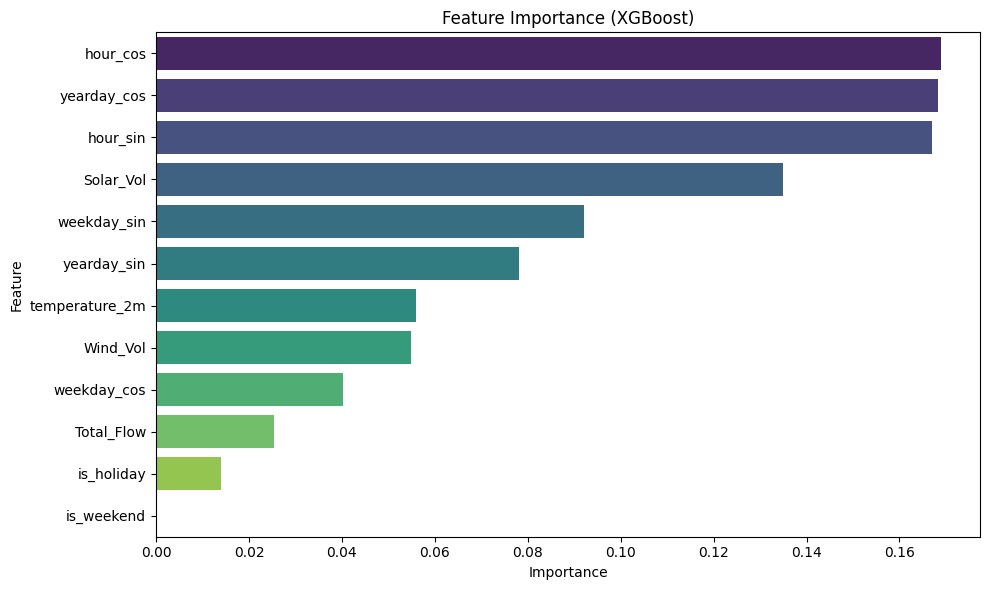

In [27]:
# Get feature importances from the last trained model
importances = model.feature_importances_
feature_names = model.feature_names_in_

# Create a DataFrame for better visualization
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feat_imp_df)

# Optional: Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()